# Causal Data Science Week 6 Tutorial

In this tutorial we will practice how to learn a causal graph using score based structure learning with the GES algorithm. We will use the python implementation of the algorithm from the package GES. You can also choose to use the GES implementation in CDT, which is a python wrapper of an R script.

## GES algorithm

Greedy Equivalence Search (GES) (https://www.jmlr.org/papers/volume3/chickering02b/chickering02b.pdf) is a score-based causal discovery algorithm. We consider the score $S(G,D)$ of a graph $G$ given the data $D$ to be computed according to the Bayesian Information Criterion (BIC) score. The algorithm constists of three steps:
1. Start with an empty CPDAG representing a MEC
2. Forward phase: add edges one by one until local maxima in BIC
3. Backward phase: remove edges one by one until local maxima in BIC 

The resulting intermediate models during the forward and backward phases are mapped to their corresponding Markov equivalence classes


In [2]:
# import necessary packages
import cdt
# cdt.SETTINGS.rpath = '/usr/local/bin/Rscript' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows

import dowhy.graph_learners.ges as dowhy_ges
import ges
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

np.random.seed(0)

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


For our experiment, we use synthetic data generated by the same SCM that we used in Tutorial 5, shown below.
$$
\begin{aligned}
X_1 &\leftarrow \epsilon_1 & \epsilon_1 &\sim \mathcal N(0,1)\\
X_2 &\leftarrow \epsilon_2 & \epsilon_2 &\sim \mathcal N(0,1)\\
X_3 &\leftarrow X_1 + X_2 + \epsilon_3 & \epsilon_3 &\sim \mathcal N(0,0.7)\\
X_4 &\leftarrow 2 X_1 + \epsilon_4 & \epsilon_4 &\sim \mathcal N(0,1.5)\\
X_5 &\leftarrow 3 X_3 + \epsilon_5 & \epsilon_5 &\sim \mathcal N(0,1)\\
\end{aligned}
$$

In [ ]:
# n_samples=10000

# eps1 = np.random.normal(0, 1, n_samples)
# eps2 = np.random.normal(0, 2, n_samples)
# eps3 = np.random.normal(0, 0.7, n_samples)
# eps4 = np.random.normal(0, 1.5, n_samples)
# eps5 = np.random.normal(0, 1, n_samples)

# x1 = eps1
# x2 = eps2
# x3 = x1 + x2 + eps3
# x4 = 2 * x1 + eps4
# x5 = 3 * x3 + eps5

# df = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4,'x5': x5})

In [4]:
df=pd.read_csv('lalonde_data.csv')
df.head()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.0460
1,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.8940
2,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.4500
3,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.1460
4,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.7899


As a reference, we can manually draw the true causal graph according to the SCM.

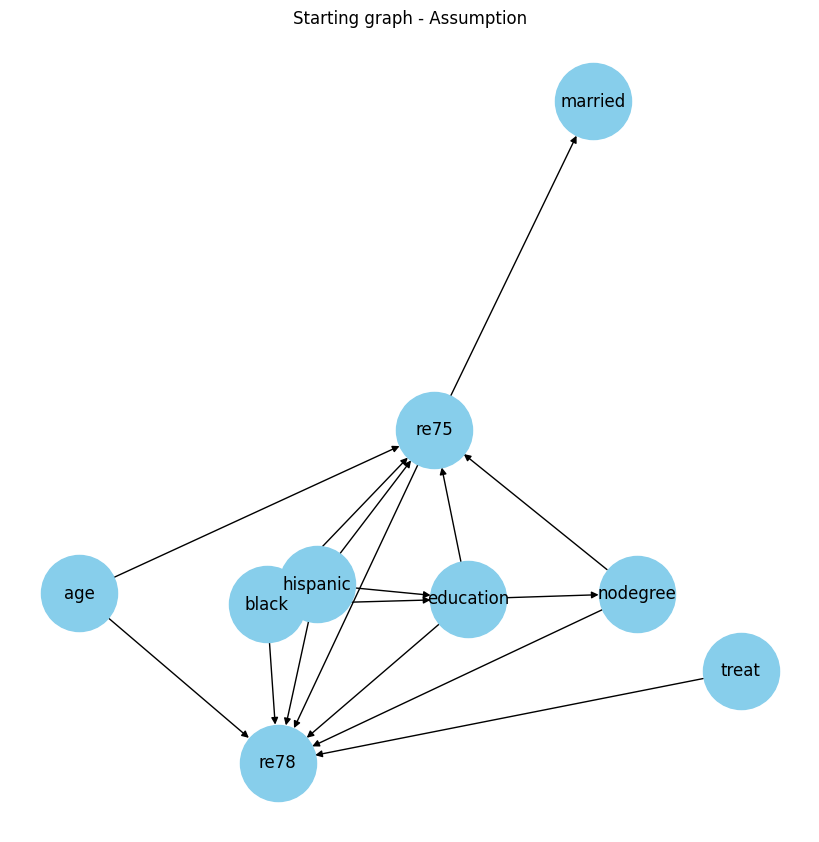

In [5]:
# nodes = [ "age"  ,"education",  "black", "hispanic", "married", "nodegree", "re75", "treat", "re78"]
# edges=[]
# for node in nodes:
#     if node == 're78':
#         continue
#     elif node == 'treat':
#         edges.append((node,'re78'))
#     else:
#         edges.append((node,'treat'))
#         edges.append((node,'re78'))
# true_graph = nx.DiGraph()
# #true_graph.add_nodes_from(nodes)
# true_graph.add_edges_from(edges)
# # plt.figure(figsize=(8, 8))
# # nx.draw(true_graph, with_labels=True, node_size=50, node_color='w', edgecolors='black')
# # plt.show()

# plt.figure(figsize=(8, 8))
# pos = nx.spring_layout(true_graph)
# nx.draw(true_graph, pos, with_labels=True, node_size=3000, node_color="skyblue")
# plt.title("Starting graph - Assumption")
# plt.show()


# nodes = [ "age"  ,"education",  "black", "hispanic", "married", "nodegree", "re75", "treat", "re78"]
# edges=[]
# var_names = ['treat','age','education','black','hispanic','married','nodegree','re75','re78']

# for node in nodes:
#     if node == 're78':
#         continue
#     elif node == 'treat':
#         edges.append((node,'re78'))
#     else:
#         edges.append((node,'treat'))
#         edges.append((node,'re78'))



nodes = [ "age"  ,"education",  "black", "hispanic", "married", "nodegree", "re75", "treat", "re78"]
edges=[]
var_names = ['treat','age','education','black','hispanic','married','nodegree','re75','re78']

true_graph = nx.DiGraph()
#true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([(var_names[0], var_names[8]), (var_names[1], var_names[7]), (var_names[1], var_names[8]), 
                  (var_names[2], var_names[7]), (var_names[2], var_names[8]), (var_names[2], var_names[6]), (var_names[6], var_names[8]),
                  (var_names[7], var_names[5]), (var_names[7], var_names[8]), (var_names[3], var_names[2]), (var_names[4], var_names[2]),
                  (var_names[3], var_names[7]), (var_names[4], var_names[7]), (var_names[3], var_names[8]), (var_names[4], var_names[8]),
                  (var_names[6], var_names[7])])
# plt.figure(figsize=(8, 8))
# nx.draw(true_graph, with_labels=True, node_size=50, node_color='w', edgecolors='black')
# plt.show()

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(true_graph)
nx.draw(true_graph, pos, with_labels=True, node_size=3000, node_color="skyblue")
plt.title("Starting graph - Assumption")
plt.show()


### Step-by-step
Before simply running GES with a simple function call on our data, let's take a closer look at the learning process. We first select our score function to be the Gaussian BIC score (this is the only score function implemented in the `ges` package) and create the initial empty CPDAG, which will be represented by adjacency matrices throughout the algorithm. Following this, we run the forward phase and then the backward phase, each until we cannot add or remove an edge that increases the score of the candidate CPDAG. Each time an edge is added or removed, the resulting DAG and its corresponding score change is computed. If the score change is positive, then we update the CPDAG according to the found DAG, and continue the phase.

In [6]:
# Containers to hold data from intermediate steps
inter_adjs = []
inter_scores = []
inter_phases = []

# Initialization
score_class = ges.scores.gauss_obs_l0_pen.GaussObsL0Pen(df.to_numpy()) # initalize the Gaussian BIC score (with numpy array)
cpdag = np.zeros((len(nodes), len(nodes))) # Initialize empty CPDAG as adjacency matrix
score = 0

# Run phases
for phase in [ges.forward_step, ges.backward_step]: # Run forward then backward phase
    print('GES {} phase start'.format(phase.__name__))
    while True: # Continue while we can increase the score in the current phase
        score_change, dag = phase(cpdag, score_class, 2) # Compute best possible score change and corresponding DAG
        if score_change > 0: # The score can be increased
            cpdag = ges.utils.pdag_to_cpdag(dag) # Get CPDAG of DAG
            score += score_change # Update total score

            # Save intermediate state
            inter_adjs.append(cpdag)
            inter_scores.append(score)
            inter_phases.append(phase.__name__)

            # Print intermediate state
            print('New score: {0:.4f}'.format(score))
            [print(row) for row in cpdag]
            print()
        else: # The score cannot be increased thus we end the phase
            break

GES forward_step phase start
  72 candidate edges
    insert(0,1,[]) -> -3.2269776066966642
    insert(0,2,[]) -> -2.1762384471535370
    insert(0,3,[]) -> -3.2900195221528747
    insert(0,4,[]) -> -2.9675225736106086
    insert(0,5,[]) -> -3.2172602561869326
    insert(0,6,[]) -> 0.2737677459967927
    insert(0,7,[]) -> -3.2857139686375376
    insert(0,8,[]) -> -1.5280776615836658
    insert(1,0,[]) -> -3.2269776066964084
    insert(1,2,[]) -> -3.0743513385338019
    insert(1,3,[]) -> -0.1431595470877483
    insert(1,4,[]) -> 1.6222505320117762
    insert(1,5,[]) -> 15.6289467820998311
    insert(1,6,[]) -> 2.0105396460883185
    insert(1,7,[]) -> -1.7026524628799962
    insert(1,8,[]) -> -3.0626511324753665
    insert(2,0,[]) -> -2.1762384471534517
    insert(2,1,[]) -> -3.0743513385339156
    insert(2,3,[]) -> -1.6106392887423908
    insert(2,4,[]) -> 5.7348367732773227
    insert(2,5,[]) -> -2.7385426134263753
    insert(2,6,[]) -> 193.6261949435501606
    insert(2,7,[]) -> -0.5291

The output above shows that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and their corresponding score changes of the insertion or deletion is calculated. The algorithm selects the best valid operation and returns the score change, and the corresponding candidate DAG. As we can see, the algorithm can add four edges to the CPDAG, but any fifth edge would result in a decreased score. After this, the algorithm cannot delete any edges for the same reason.

We can also visualize the whole process by drawing the intermediate CPDAG at each step. We can see how the number of edges grows during forward steps, and how the algorithm transitions between CPDAGs defining different v-structures (from step 2 to 3).

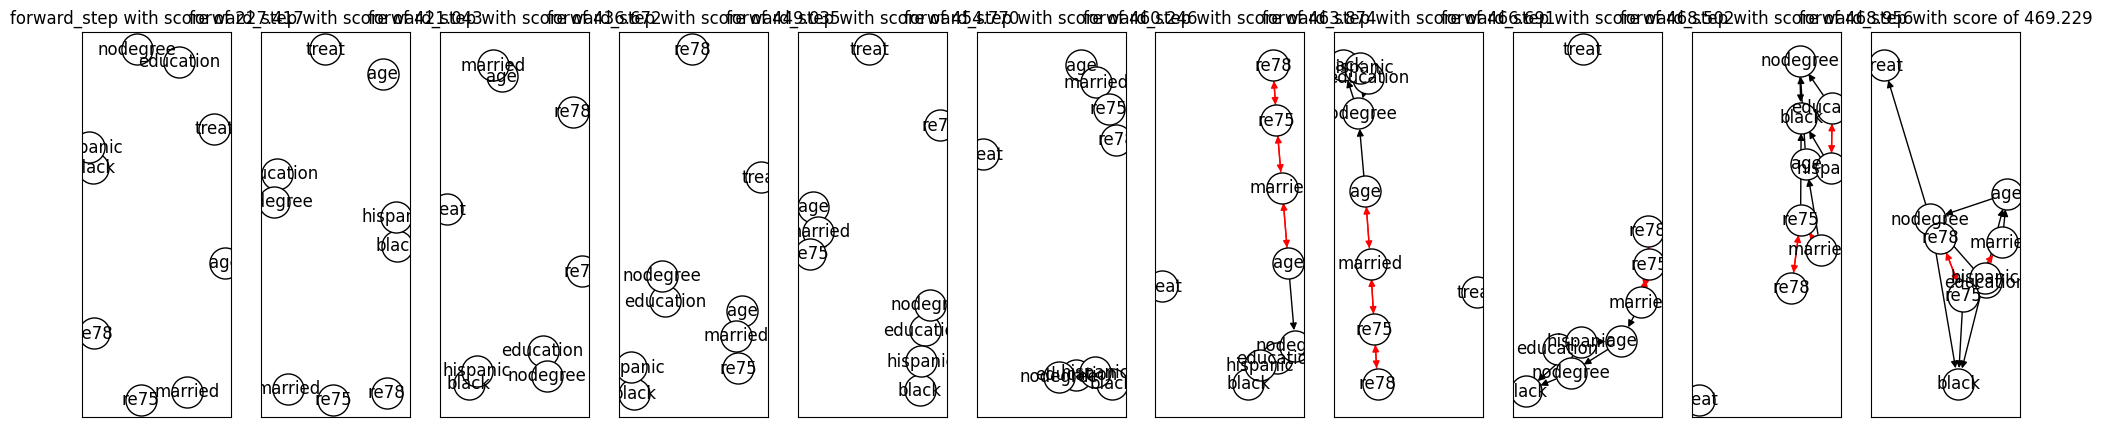

In [7]:
fig, axs = plt.subplots(1, len(inter_adjs), figsize=(25, 5))
for ax, adj, score, phase in zip(axs, inter_adjs, inter_scores, inter_phases):
    G = nx.relabel_nodes(nx.DiGraph(adj), {idx: i for idx, i in enumerate(df.columns)})
    colors = ['red'  if (y,x) in G.edges() else 'black' for (x,y) in G.edges()]
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, ax=ax, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos,
                     edge_color=colors)
    ax.set_title(phase + ' with score of {0:.3f}'.format(score))
plt.show()

### End-to-end
If we only care about the end result, then we can simply call the `fit_bic` function ([reference](https://github.com/juangamella/ges#using-the-gaussian-bic-score-gesfit_bic)). This includes a "turning phase" (https://www.jmlr.org/papers/volume13/hauser12a/hauser12a.pdf) that improves the GES algorithm, which we did not cover in the class or this tutorial. The parameters of this function allow you to turn the turning phase off, as well as define the initial CPDAG and control whether you wish to run phases in a loop. However, the standard parameters should work best for most cases.

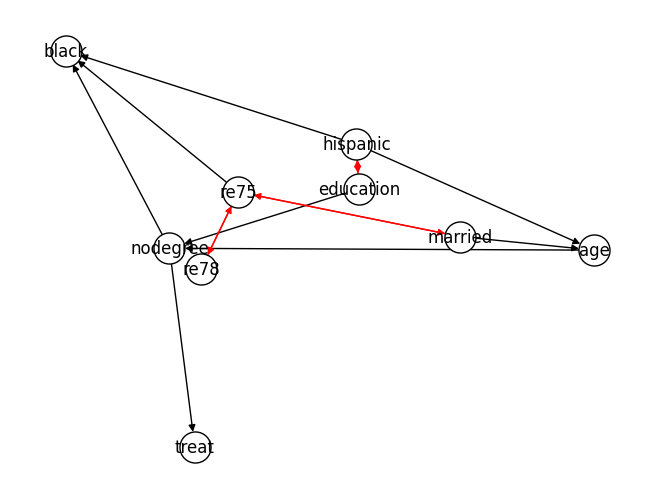

In [8]:
result, score = ges.fit_bic(df.to_numpy()) # The result is a CPDAG represented by an adjacency matrix
ges_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in ges_graph.edges() else 'black' for (x,y) in ges_graph.edges()]
pos = nx.spring_layout(ges_graph)
nx.draw(ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)
#pos = nx.spring_layout(ges_graph)
#nx.draw(ges_graph, pos, with_labels=True, node_size=3000, node_color="skyblue")
#plt.show()

If you prefer to not convert your dataframe to a numpy array manually, you can use the `dowhy` wrapper for the ges package instead ([reference](https://www.pywhy.org/dowhy/v0.9.1/dowhy.graph_learners.html#dowhy.graph_learners.ges.GES)).

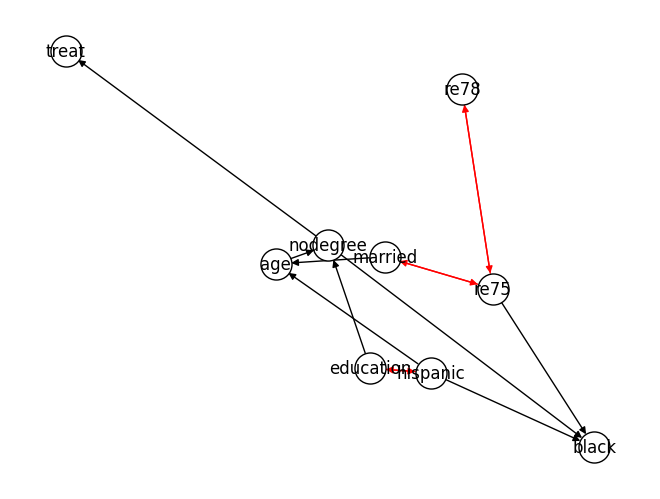

In [9]:
learner = dowhy_ges.GES(df, 'ges') # Notice that we don't pass df.to_numpy()
learner.learn_graph()
dowhy_ges_graph = nx.relabel_nodes(nx.DiGraph(learner._adjacency_matrix), {idx: i for idx, i in enumerate(df.columns)})
colors = ['red'  if (y,x) in dowhy_ges_graph.edges() else 'black' for (x,y) in dowhy_ges_graph.edges()]
pos = nx.spring_layout(dowhy_ges_graph)
#nx.draw(dowhy_ges_graph, pos, with_labels=True, node_size=3000, node_color="skyblue")
nx.draw(dowhy_ges_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

You can also use the GES wrapper from the `cdt` package as shown below ([reference](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html?highlight=ges#ges)).

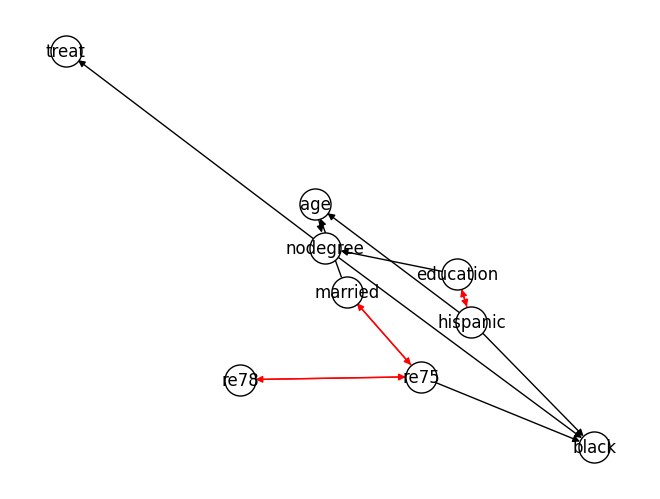

In [10]:
cdt_gres_graph = cdt.causality.graph.GES(score='obs').predict(df)
colors = ['red'  if (y,x) in cdt_gres_graph.edges() else 'black' for (x,y) in cdt_gres_graph.edges()]
pos = nx.spring_layout(cdt_gres_graph)
nx.draw(cdt_gres_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)


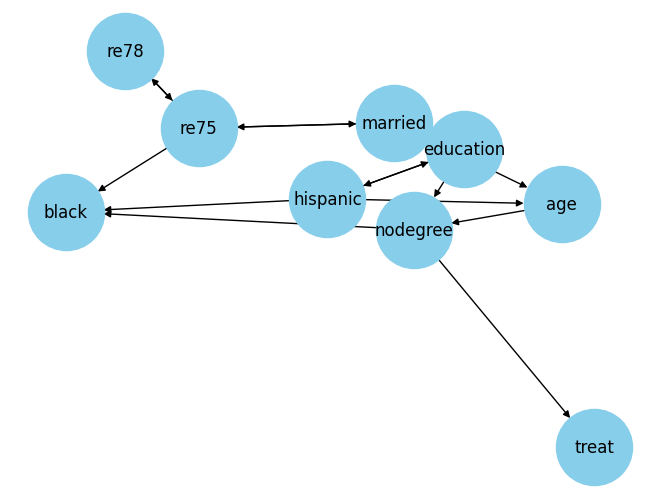

In [13]:
#nx.draw(cdt_gres_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

pos = nx.spring_layout(cdt_gres_graph)
nx.draw(cdt_gres_graph, pos, with_labels=True, node_size=3000, node_color="skyblue")